In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.illutrative_problems import Forrester1b
from mfbml.metrics.accuracy_metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfbml.methods.mf_rbf_gpr import MFRBFGPR

# fix the random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# define function
func = Forrester1b(noise_std=0.1)
num_dim = 1

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(-1, 2, 201).reshape(-1, 1)
hf_samples = torch.linspace(0, 1, 7).reshape(-1, 1)


# generate responses
lf_responses = func.lf(lf_samples)
hf_responses = func.hf(hf_samples)

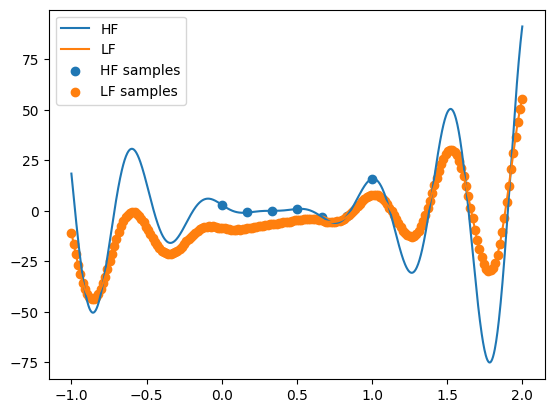

In [3]:
# generate the test points
test_samples = torch.linspace(-1, 2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf(test_samples, noise_lf=0.0)

# noise responses
test_hf_responses = func.hf(test_samples)
test_lf_responses = func.lf(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot test noisy responses
# ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
# ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

## Configurations for DNN and BNNs


In [4]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.01,
    "weight_decay": 0.001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 20000,
    "print_iter": 100,
    "data_split": True,
}
hf_train_config = {
    "num_epochs": 5000,
    "sample_freq": 50,
    "print_info": True,
    "burn_in_epochs": 500,
}

# training of sequential MF-DNN-BNN model


In [5]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  100 train loss:  0.6647602319717407 test loss:  0.5060093402862549
epoch:  200 train loss:  0.6376125812530518 test loss:  0.4936905801296234
epoch:  300 train loss:  0.5987223386764526 test loss:  0.4737328886985779
epoch:  400 train loss:  0.5683470368385315 test loss:  0.45691564679145813
epoch:  500 train loss:  0.5506442785263062 test loss:  0.4548366963863373
epoch:  600 train loss:  0.5362808108329773 test loss:  0.4561309814453125
epoch:  700 train loss:  0.4937993586063385 test loss:  0.45432257652282715
epoch:  800 train loss:  0.19487620890140533 test loss:  0.23076485097408295
epoch:  900 train loss:  0.03633560240268707 test loss:  0.06130188703536987
epoch:  1000 train loss:  0.01696527935564518 test loss:  0.024016790091991425
epoch:  1100 train loss:  0.009279998019337654 test loss:  0.011199697852134705
epoch:  1200 train loss:  0.007505244575440884 test loss:  0.008529099635779858
epoch:  1300 train loss:  0.009899144060909748 test loss:  0.008500481955707073


In [ ]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.predict_lf(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
ax.plot(test_samples.numpy(), sequential_bnn_lf_y.detach(), label="lf prediction")
ax.plot(
    test_samples.numpy(),
    test_lf_responses_noiseless.numpy(),
    label="lf ground truth",
)
ax.legend()
plt.show()

In [ ]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=False,
    beta_bounds=[-5, 5],
)
# define beta
mfdnnbnn.beta = np.array([1.95, 2.06])
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.predict_lf(test_samples)

In [ ]:
mfdnnbnn.beta = np.array([1.95, 2.06])

In [ ]:
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [ ]:
# to have a gpr model for this problem
samples_gpr = {"lf": lf_samples.numpy(), "hf": hf_samples.numpy()}
responses_gpr = {"lf": lf_responses.numpy(), "hf": hf_responses.numpy()}

# create the MFRBFGPR object
mfrbfgpr = MFRBFGPR(
    design_space=np.array([[0, 1]]), noise_prior=0.1, optimizer_restart=20
)
# train the model
mfrbfgpr.train(
    samples=samples_gpr,
    responses=responses_gpr,
)

# get prediciton for the MFRBFGPR object
y_mfrbfgpr, total_unc_mfrbfgpr = mfrbfgpr.predict(
    X=test_samples.numpy(), return_std=True
)

In [ ]:
# plot two figures together
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# plot sequential mf-bnn
ax[0].plot(hf_samples, hf_responses, "o", label="hf")
ax[0].plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
# ax[0].scatter(lf_samples, lf_responses, label="LF samples")
ax[0].plot(
    test_samples.numpy(), sequential_bnn_lf_y.detach().numpy(), label="LF prediction"
)
ax[0].legend()
ax[0].set_title("Sequential MF-BNN")
# ax[0].set_xlim([0, 1.5])

# plot MFRBFGPR
ax[1].plot(hf_samples, hf_responses, "o", label="hf")
ax[1].plot(test_samples.numpy(), y_mfrbfgpr, label="hf prediction")
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
ax[1].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    label="LF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    y_mfrbfgpr - 1.9144 * mfrbfgpr.lf_model.predict(test_samples.numpy()),
    label=r"$f^d(x)$",
)
ax[1].legend()
ax[1].set_title("MFRBFGPR")
# ax[1].set_xlim([0, 1.5])

# plot MFDNNBNN
ax[2].plot(hf_samples, hf_responses, "o", label="hf")
ax[2].plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
# ax[1].plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax[2].plot(
    test_samples.numpy(), lf_y_proposed.detach().numpy(), label=r"$\beta f^l(x) $"
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed - 1.9144 * lf_y_proposed.detach().numpy(),
    label=r"$f^d(x)$",
)

ax[2].legend()
ax[2].set_title("MFDNNBNN")
# ax[1].set_xlim([0, 1.5])
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
mfrbfgpr.beta

In [ ]:
# plot the results of mf-dnn-bnn
residual = y_proposed - 1.9144 * lf_y_proposed.detach().numpy()
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
# ax.scatter(lf_samples, lf_responses, label="LF samples")
# ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label=r"$\beta f^l(x) $")
ax.plot(
    test_samples.numpy(),
    y_proposed - 1.9144 * lf_y_proposed.detach().numpy(),
    label=r"$f^d(x)$",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=14)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
plt.tight_layout()
ax.set_xlim([0, 1.5])
plt.show()

In [ ]:
ax[1].plot(
    samples["hf"].numpy(),
    responses["hf"].numpy(),
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)

ax[1].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).flatten(),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)

In [ ]:
# plot comparison between
# plot two figures together
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


# plot MFRBFGPR
ax[0].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
ax[0].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr - 1.9144 * mfrbfgpr.lf_model.predict(test_samples.numpy()),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[0].legend()
ax[0].set_title("MF-RBF-GPR")
ax[0].set_xlabel("x", fontsize=12)
ax[0].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[0].tick_params(axis="both", which="major", labelsize=12)
# ax[1].set_xlim([0, 1.5])

# plot MFDNNBNN
ax[1].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
# ax[1].plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax[1].plot(
    test_samples.numpy(),
    lf_y_proposed.detach().numpy(),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed - 1.9144 * lf_y_proposed.detach().numpy(),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[1].legend()
ax[1].set_title("MF-DNN-BNN")
ax[1].set_xlabel("x", fontsize=12)
ax[1].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[1].tick_params(axis="both", which="major", labelsize=12)
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()